In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## Preliminaries

In [531]:
# Reading in example response times (RT) data
df = pd.read_csv('../data/rt_example_data.csv', delimiter=';')

In [532]:
# Explore the top five rows
df.head()

,#TIME,TRIAL,RESPONSE,RT,PRIME,TARGET,TYPE,RESULT,QUESTION
0,82.2292,1,0,0.4851,0,1,incongruent,incorrect,0
1,85.9700,2,0,0.5515,1,0,incongruent,correct,0
2,89.2500,3,1,0.6348,1,0,congruent,incorrect,0
3,92.6600,4,0,0.7683,0,0,congruent,correct,0
4,96.5800,5,1,0.5181,1,1,incongruent,correct,0


Text(0, 0.5, 'Frequency')

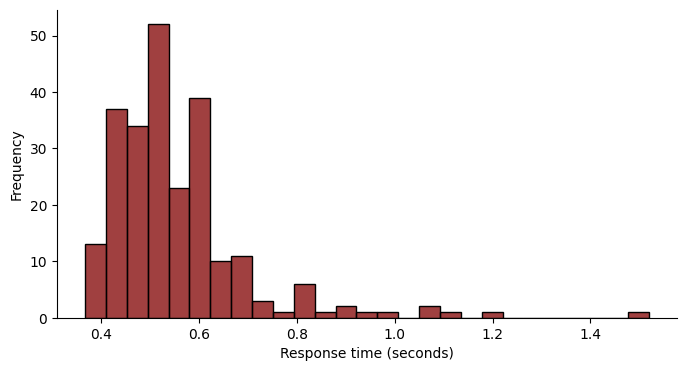

In [533]:
# Simple way to create a nice histogram of all RTs
rts = df.RT.values
f, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.histplot(rts[rts<=3.0], color='maroon', ax=ax)
sns.despine(ax=ax)
ax.set_xlabel('Response time (seconds)')
ax.set_ylabel('Frequency')

## Coding Random Walks

In [534]:
def simulate_discrete_rw(T=1000):
    """Simulates a simple discrete random walk given a time horizon T."""

    x = np.zeros(shape=T)
    for t in range(1, T):
        w = np.random.randint(low=0, high=2)
        w = -1 if w == 0 else 1
        x[t] = x[t-1] + w
    return x


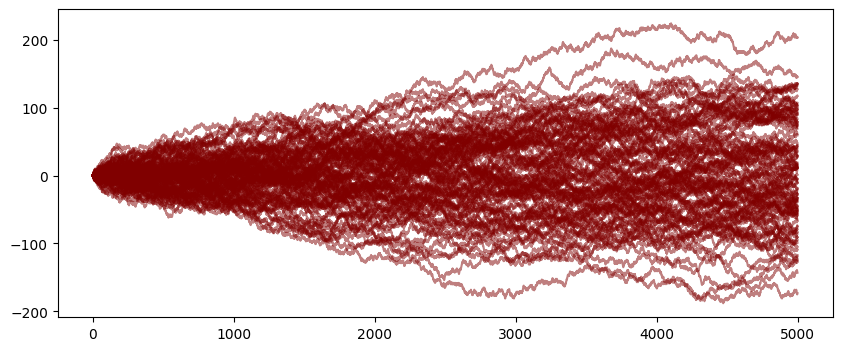

In [535]:
# Visualize a few random walkers
num_walks = 100
f, ax = plt.subplots(1, 1, figsize=(10, 4))

for _ in range(num_walks):
    x = simulate_discrete_rw(T=5000)
    ax.plot(x, color='maroon', alpha=0.5)

In [536]:
def simulate_random_walk(T: int = 100, sigma: float = 1.0) -> np.ndarray:
    """Simulates one realization of a discrete random walk process.
    
    Parameters:
    -----------
    T     : int, optional (default: 100)
        The time horizon of the process
    sigma : float, optional (default: 1.0)
        The scale (sqrt(variance)) of the random steps.

    Returns:
    --------
    x : np.ndarray of shape (T, )
        An array containing the simulated random walk trajectory.
    """

    x = np.zeros(T)
    for t in range(1, T):
        x[t] = x[t-1] + sigma*np.random.normal(loc=0., scale=1)
    return x


def simulate_random_walk_noloop(T: int = 100, sigma: float = 1.0) -> np.ndarray:
    """Simulates one realization of a discrete random walk process.
    
    Parameters:
    -----------
    T     : int, optional (default: 100)
        The time horizon of the process
    sigma : float, optional (default: 1.0)
        The scale (sqrt(variance)) of the random steps.

    Returns:
    --------
    x : np.ndarray of shape (T, )
        An array containing the simulated random walk trajectory.
    """

    z = np.random.normal(loc=0., scale=sigma, size=T)
    z[0] = 0
    return np.cumsum(z)

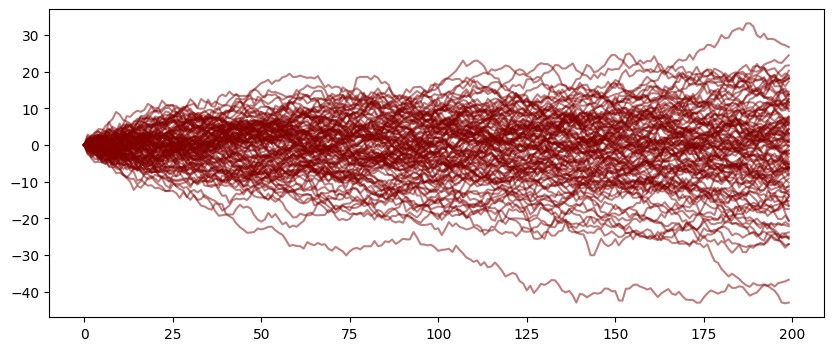

In [537]:
# Visualize 'num_walks' realizations of the inefficiently implemented process
num_walks = 100
f, ax = plt.subplots(1, 1, figsize=(10, 4))

for _ in range(num_walks):
    x = simulate_random_walk(T=200) 
    ax.plot(x, color='maroon', alpha=0.5)

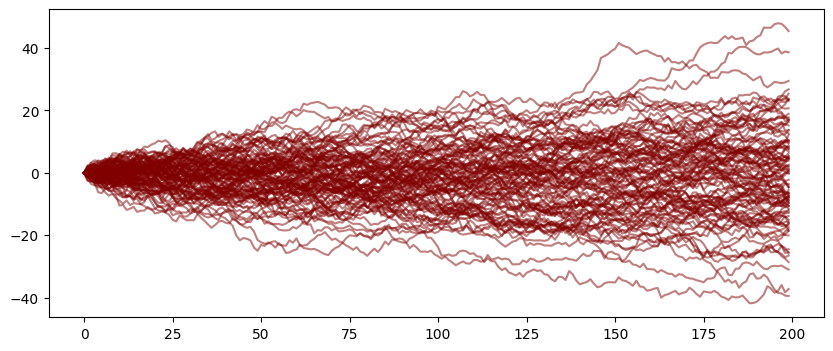

In [538]:
# Visualize 'num_walks' realizations of the efficiently implemented process
num_walks = 100
f, ax = plt.subplots(1, 1, figsize=(10, 4))

for _ in range(num_walks):
    x = simulate_random_walk_noloop(T=200)
    ax.plot(x, color='maroon', alpha=0.5)

In [539]:
def simulate_random_walk_multiple(N=10, T=500, scale=1.):
    """Nice docstring..."""

    # Draw random Gaussian variates
    z = np.random.normal(loc=0., scale=scale, size=(N, T))

    # Apply cumulative sum over time axis
    r = np.cumsum(z, axis=1)

    # Return result
    return r


def visualize_random_walks(trajectories):
    """Produces a simple plot of multiple random walk trajectories.
    
    Parameters:
    -----------
    
    trajectories : np.ndarray of shape (N, T)
        The `T` Random Walk realizations.

    Returns:
    --------
    f : plt.Figure
        The figure instance (for saving etc...)
    """

    f, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.plot(trajectories.T, color='maroon', alpha=0.7)
    sns.despine(ax=ax)
    ax.set_xlabel('Time (t)')
    ax.set_ylabel('Process value')
    return f

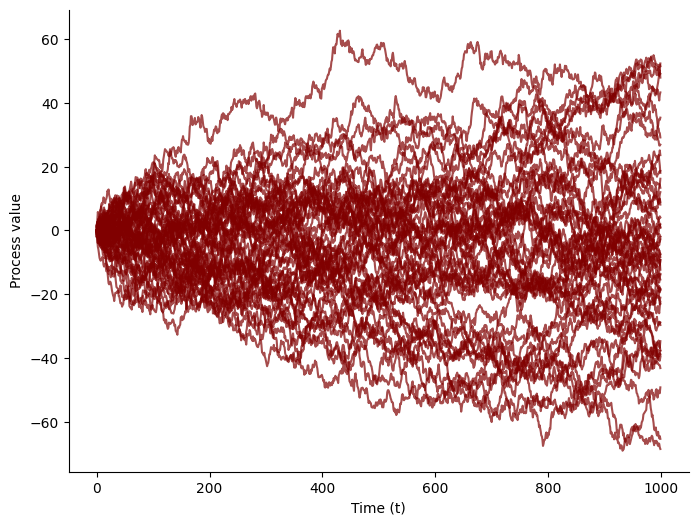

In [540]:
trajectories = simulate_random_walk_multiple(50, 1000)
f = visualize_random_walks(trajectories)

## Simulating the Drift Diffusion Model

As we discussed in class, the Drift Diffusion Model (DDM) is a widely used cognitive process model for decision-making in two-alternative forced-choice tasks. It conceptualizes decision-making as a noisy accumulation of evidence over time, with a decision reached when the accumulated evidence crosses a threshold. The DDM captures key behavioral measures, such as accuracy and response times, and provides insights into cognitive processes like speed-accuracy trade-offs. This notebook simulates the DDM and explores its fundamental properties.

In [541]:
def simulate_diffusion(v, a, beta, tau, dt=1e-3, scale=1.0, max_time=10.):
    """
    Simulates one realization of the diffusion process given
    a set of parameters and a step size `dt`.

    Parameters:
    -----------
    v     : float
        The drift rate (rate of information uptake)
    a     : float
        The boundary separation (decision threshold).
    beta  : float in [0, 1]
        Relative starting point (prior option preferences)
    tau   : float
        Non-decision time (additive constant)
    dt    : float, optional (default: 1e-3 = 0.001)
        The step size for the Euler algorithm.
    scale : float, optional (default: 1.0)
        The scale (sqrt(var)) of the Wiener process. Not considered
        a parameter and typically fixed to either 1.0 or 0.1.
    max_time: float, optional (default: .10)
        The maximum number of seconds before forced termination.

    Returns:
    --------
    (x, c) - a tuple of response time (y - float) and a 
        binary decision (c - int) 
    """

    # Inits (process starts at relative starting point)
    y = beta * a
    num_steps = tau
    const = scale*np.sqrt(dt)

    # Loop through process and check boundary conditions
    while (y <= a and y >= 0) and num_steps <= max_time:

        # Perform diffusion equation
        z = np.random.randn()
        y += v*dt + const*z

        # Increment step counter
        num_steps += dt

    if y >= a:
        c = 1.
    else:
        c = 0.
    return (round(num_steps, 3), c)


def simulate_diffusion_n(num_sims, v, a, beta, tau, dt=1e-3, scale=1.0, max_time=10.):
    """Add a nice docstring."""

    data = np.zeros((num_sims, 2))
    for n in range(num_sims):
        data[n, :] = simulate_diffusion(v, a, beta, tau, dt, scale, max_time)
    return data


def visualize_diffusion_model(data, figsize=(8, 6)):
    """Add a nice docstring."""
    f, ax = plt.subplots(1, 1, figsize=figsize)
    sns.histplot(data[:, 0][data[:, 1] == 1], color='maroon', alpha=0.7, ax=ax, label='Correct responses')
    sns.histplot(data[:, 0][data[:, 1] == 0], color='gray', ax=ax, label='Incorrect responses')
    sns.despine(ax=ax)
    ax.set_xlabel('Response time (s)', fontsize=18)
    ax.set_ylabel('')
    ax.legend(fontsize=18)
    ax.set_yticks([])
    return f

In [542]:
params = {
    'v': 1,
    'a': 3,
    'beta': 0.5,
    'tau': 0.7
}

In [543]:
%%time
data = simulate_diffusion_n(1000, **params)

CPU times: total: 969 ms
Wall time: 967 ms


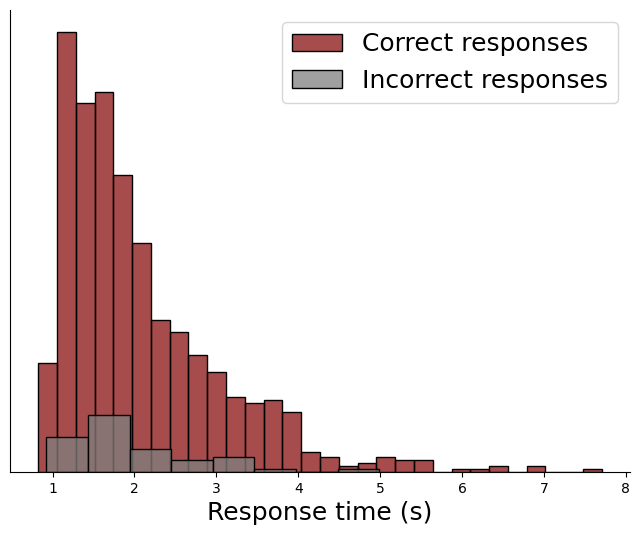

In [544]:
f = visualize_diffusion_model(data)
f.savefig('test_diffusion_output.png', dpi=300)

## Simulating the Leaky Competing Accumulator Model

The Leaky Competing Accumulator (LCA) model extends simple evidence accumulation frameworks by incorporating leakage (decay of accumulated evidence) and competition (mutual inhibition between choice alternatives). This model accounts for dynamic decision-making processes, particularly in tasks where multiple alternatives are considered simultaneously. By integrating accumulation, decay, and inhibition, the LCA model provides a more biologically plausible representation of decision-making. This notebook simulates the LCA model and examines how its parameters influence choice behavior.

In [ ]:
def simulate_lca(v : np.ndarray, x0 : np.ndarray, a : float, beta : float, kappa : float, tau : float, dt : float =1e-3, scale : float =1.0, max_time : float=10.) -> tuple[float, bool]:
    """
    Simulates one realization of the diffusion process given
    a set of parameters and a step size `dt`.

    Parameters:
    -----------
    v     : np.ndarray
        The drift rates (rates of information uptake)
    x0    : np.ndarray
        The starting points
    a     : float
        The boundary separation (decision threshold).
    beta  : float in [0, inf+)
        Inhibition parameter
    kappa : float in [0, 1]
        Leakage parameter
    tau   : float [0 , inf+)
        Non-decision time (additive constant)
    dt    : float, optional (default: 1e-3 = 0.001)
        The step size for the Euler algorithm.
    scale : float, optional (default: 1.0)
        The scale (sqrt(var)) of the Wiener process. Not considered
        a parameter and typically fixed to either 1.0 or 0.1.
    max_time: float, optional (default: 10.)
        The maximum number of seconds before forced termination.

    Returns:
    --------
    (x, c) - a tuple of response time (y - float) and a 
        binary decision (c - int) 
    """

    

    # Inits (process starts at relative starting point)
    x = x0
    t = tau
    # const = scale*np.sqrt(dt)

    # Loop through process and check boundary conditions
    while (np.any(x <= a)) and t <= max_time:

        # Perform diffusion equation
        z = np.random.randn(x.shape[0])
        I = (beta * np.sum(x[:1:])) * np.ones(x.shape)
        x += (v - I - kappa*x)*dt + scale*z
        if(np.any(x < 0)):
            print("Negative X")
            break

        # Increment step counter
        t += dt

    return (t, np.argmax(x))

In [546]:
def simulate_lca_n(num_sims, parameters):

    data = []
    for n in range(num_sims):
        data.append(simulate_lca(parameters['v'], parameters['x0'], parameters['a'], parameters['beta'], parameters['kappa'], parameters['tau']))
    return data

Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X
Negative X

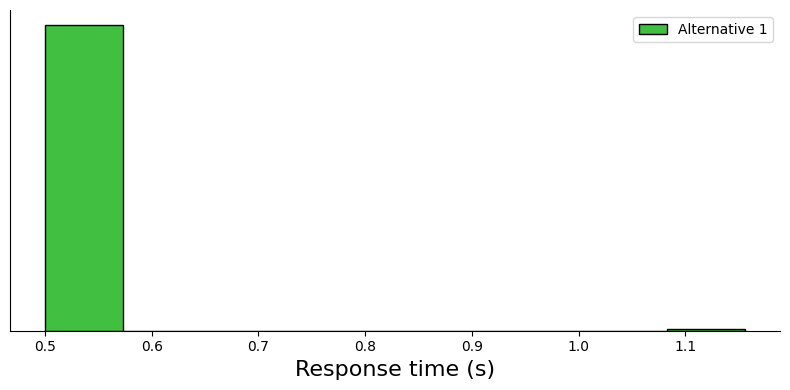

In [547]:
# Simulation parameters
parameters = {
    'v': np.array([1., 1., 3.]),
    'x0': np.zeros(3),
    'a': 1.,
    'tau': 0.5,
    'beta': 0.6,
    'kappa': 0.2
}

# Simulator (for n_obs)


sim_data = np.array(simulate_lca_n(200, parameters=parameters))
print(sim_data)


# Visualize empirical RT distribution
f, ax = plt.subplots(1, 1, figsize=(8, 4))
colors = ['#AA0000', '#00AA00', '#0000AA']
for j in range(parameters['v'].shape[0]):
    sns.histplot(sim_data[:, 0][sim_data[:, 1] == j], color=colors[j], label=f'Alternative {j}')
ax.legend()
sns.despine(ax=ax)
ax.set_xlabel('Response time (s)', fontsize=16)
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_yticks([])
f.tight_layout()

In [548]:
sim_data

array([[1.156, 1.   ],
       [0.5  , 1.   ],
       [0.5  , 1.   ],
       [0.5  , 1.   ],
       [0.5  , 1.   ],
       [0.5  , 1.   ],
       [0.5  , 1.   ],
       [0.5  , 1.   ],
       [0.5  , 1.   ],
       [0.5  , 1.   ],
       [0.5  , 1.   ],
       [0.5  , 1.   ],
       [0.5  , 1.   ],
       [0.5  , 1.   ],
       [0.5  , 1.   ],
       [0.5  , 1.   ],
       [0.5  , 1.   ],
       [0.5  , 1.   ],
       [0.5  , 1.   ],
       [0.5  , 1.   ],
       [0.5  , 1.   ],
       [0.5  , 1.   ],
       [0.5  , 1.   ],
       [0.5  , 1.   ],
       [0.5  , 1.   ],
       [0.5  , 1.   ],
       [0.5  , 1.   ],
       [0.5  , 1.   ],
       [0.5  , 1.   ],
       [0.5  , 1.   ],
       [0.5  , 1.   ],
       [0.5  , 1.   ],
       [0.5  , 1.   ],
       [0.5  , 1.   ],
       [0.5  , 1.   ],
       [0.5  , 1.   ],
       [0.5  , 1.   ],
       [0.5  , 1.   ],
       [0.5  , 1.   ],
       [0.5  , 1.   ],
       [0.5  , 1.   ],
       [0.5  , 1.   ],
       [0.5  , 1.   ],
       [0.5